In [51]:
from pypokerengine.api.game import setup_config, start_poker
from pypokerengine.players import BasePokerPlayer
from pypokerengine.engine.card import Card
from raise_player import RaisedPlayer

import numpy as np
from matplotlib import pyplot as plt

In [3]:

from typing import Dict, Literal, List, TypedDict, Tuple

ALL_CARDS = tuple(s + r for s in Card.SUIT_MAP.values() for r in Card.RANK_MAP.values())
CardString = Literal[ALL_CARDS]
PlayerUUID = str
Street = Literal["preflop", "flop", "turn", "river", "showdown"]
Action = Literal["fold", "call", "raise"]

class ActionOption(TypedDict):
    action: Action

class ActionUpdate(TypedDict):
    player_uuid: PlayerUUID
    action: Action
    amount: int

class ActionHistory(TypedDict):
    action: Literal["SMALLBLIND", "BIGBLIND", "FOLD", "CALL", "RAISE"]
    amount: int
    add_amount: int
    uuid: PlayerUUID

class MainPot(TypedDict):
    amount: int

class SidePot(TypedDict):
    amount: int
    eligibles: List[PlayerUUID]

class Pot(TypedDict):
    main: MainPot
    side: List[SidePot]

class Seat(TypedDict):
    name: str
    uuid: PlayerUUID
    stack: int
    state: Literal["participating", "folded", "allin"]

class RoundState(TypedDict):
    street: Street
    pot: Pot
    community_card: List[CardString]
    dealer_btn: int
    next_player: int
    small_blind_pos: int
    big_blind_pos: int
    round_count: int
    small_blind_amount: int
    seats: List[Seat]
    action_histories: Dict[Street, List[ActionHistory]]

class BlindStructureLevel(TypedDict):
    ante: int
    small_blind: int

BlindStructure = Dict[int, BlindStructureLevel]

class GameInfoRule(TypedDict):
    initial_stack: int
    max_round: int
    small_blind_amount: int
    ante: int
    blind_structure: BlindStructure


class GameInfo(TypedDict):
    player_num: int
    rule: GameInfoRule
    seats: List[Seat]

class HandDetails(TypedDict):
    strength: Literal["HIGHCARD", "ONEPAIR", "TWOPAIR", "THREEOFKIND", "STRAIGHT", "FLUSH", "FULLHOUSE", "FOUROFAKIND", "STRAIGHTFLUSH", "ROYALFLUSH"]
    high: int
    low: int

class HoleDetails(TypedDict):
    high: int
    low: int

class Hand(TypedDict):
    hand: HandDetails
    hole: HoleDetails

class HandInfo(TypedDict):
    uuid: PlayerUUID
    hand: Hand

class TypedPokerPlayer(BasePokerPlayer):
    def declare_action(self, valid_actions: List[ActionOption], hole_card: List[CardString], round_state: RoundState) -> Action:
        # pprint(valid_actions, indent=4, sort_dicts=False)
        if "raise" in [action["action"] for action in valid_actions]:
            return "raise"
        elif "call" in [action["action"] for action in valid_actions]:
            return "call"
        else:
            return "fold"
        return super().declare_action(valid_actions, hole_card, round_state)

    def receive_game_start_message(self, game_info: GameInfo) -> None:
        pass

    def receive_round_start_message(self, round_count: int, hole_card: List[CardString], seats: List[Seat]) -> None:
        pass

    def receive_street_start_message(self, street: Street, round_state: RoundState) -> None:
        # pprint(round_state)
        pass

    def receive_game_update_message(self, action: ActionUpdate, round_state: RoundState) -> None:
        pass

    def receive_round_result_message(self, winners: List[Seat], hand_info: HandInfo, round_state: RoundState) -> None:
        pass

In [7]:
config = setup_config(max_round=1, initial_stack=10000, small_blind_amount=10)
config.register_player(name="f1", algorithm=TypedPokerPlayer())
config.register_player(name="FT2", algorithm=TypedPokerPlayer())
game_result = start_poker(config, verbose=1)

Started the round 1
Street "preflop" started. (community card = [])
"FT2" declared "raise:40"
"f1" declared "raise:60"
"FT2" declared "raise:80"
"f1" declared "call:80"
Street "flop" started. (community card = ['D4', 'DA', 'DT'])
"FT2" declared "raise:20"
"f1" declared "raise:40"
"FT2" declared "raise:60"
"f1" declared "raise:80"
"FT2" declared "call:80"
Street "turn" started. (community card = ['D4', 'DA', 'DT', 'S4'])
"FT2" declared "call:0"
"f1" declared "raise:40"
"FT2" declared "call:40"
Street "river" started. (community card = ['D4', 'DA', 'DT', 'S4', 'SQ'])
"FT2" declared "call:0"
"f1" declared "call:0"
"['FT2']" won the round 1 (stack = {'f1': 9800, 'FT2': 10200})


In [8]:
game_result

{'rule': {'initial_stack': 10000,
  'max_round': 1,
  'small_blind_amount': 10,
  'ante': 0,
  'blind_structure': {}},
 'players': [{'name': 'f1',
   'uuid': 'ewuoybtbzzjzhcjvwohzff',
   'stack': 9800,
   'state': 'participating'},
  {'name': 'FT2',
   'uuid': 'ddszzxroepirowmbfyrxds',
   'stack': 10200,
   'state': 'participating'}]}

In [9]:
def evaluate_agents(player1_cls: BasePokerPlayer, player2_cls: BasePokerPlayer, num_games: int = 100):
    results = []

    for i in range(num_games):
        config = setup_config(max_round=1, initial_stack=10000, small_blind_amount=10)
        config.register_player(name="Player1", algorithm=player1_cls())
        config.register_player(name="Player2", algorithm=player2_cls())

        game_result = start_poker(config, verbose=0)
        p1_stack = game_result["players"][0]["stack"]
        p2_stack = game_result["players"][1]["stack"]

        results.append((p1_stack, p2_stack))

    return results

In [17]:
def estimate_exploitability(agent_cls, br_cls, hands=1000):
    # agent_cls is being evaluated, br_cls tries to exploit it
    results_as_sb = evaluate_agents(agent_cls, br_cls, num_games=hands // 2)
    results_as_bb = evaluate_agents(br_cls, agent_cls, num_games=hands // 2)

    losses = []
    for (p1_stack, p2_stack) in results_as_sb:
        losses.append(10000 - p1_stack)  # agent is SB
    for (p1_stack, p2_stack) in results_as_bb:
        losses.append(10000 - p2_stack)  # agent is BB

    avg_loss = sum(losses) / len(losses)
    exploitability_mbb = avg_loss / 10  # 10 = 1bb, so mbb = avg_loss * 1000 / bb
    return exploitability_mbb

In [21]:
from raise_player import RaisedPlayer

estimate_exploitability(RaisedPlayer, RaisedPlayer, hands = 30_000)

0.09466666666666666

In [22]:
from randomplayer import RandomPlayer

estimate_exploitability(RandomPlayer, RandomPlayer, hands = 30_000)

-0.008666666666666666

In [23]:
estimate_exploitability(RandomPlayer, RaisedPlayer, hands = 30_000)

5.381966666666667

In [32]:
def play_round(player1_cls: BasePokerPlayer, player2_cls: BasePokerPlayer):
    config = setup_config(max_round=1, initial_stack=10000, small_blind_amount=10)
    config.register_player(name="Player1", algorithm=player1_cls())
    config.register_player(name="Player2", algorithm=player2_cls())

    game_result = start_poker(config, verbose=0)
    p1_stack = game_result["players"][0]["stack"] - 10000
    p2_stack = game_result["players"][1]["stack"] - 10000

    return p1_stack, p2_stack

def test_agents(player1_cls: BasePokerPlayer, player2_cls: BasePokerPlayer, num_games: int = 100):
    player1_stack_history = []

    for i in range(num_games):
        if i % 2 == 0:
            p1_stack, p2_stack = play_round(player1_cls, player2_cls)
        else:
            p2_stack, p1_stack = play_round(player2_cls, player1_cls)
        player1_stack_history.append(p1_stack)

    return player1_stack_history

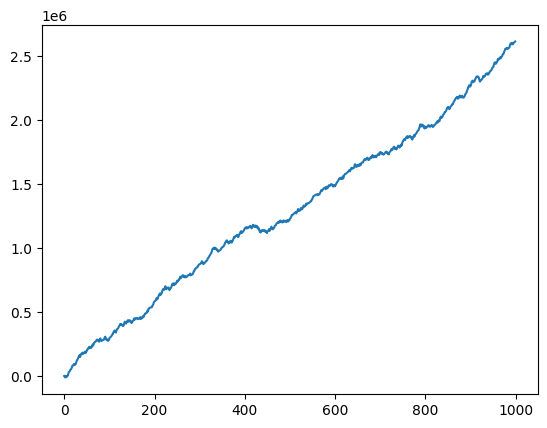

In [58]:
history = test_agents(RaisedPlayer, RandomPlayer, num_games=1_000)
history = np.array(history) * 1000 / 20 # convert to mbb
cumulative_sum = np.cumsum(history)
plt.plot(cumulative_sum)

2612.5


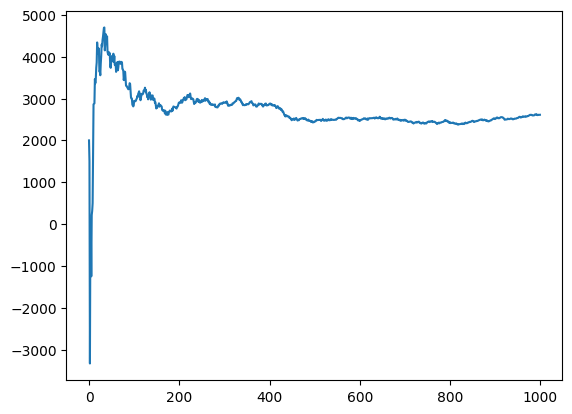

In [59]:
avg_change_over_time = cumulative_sum / np.arange(1, len(cumulative_sum) + 1)
print(avg_change_over_time[-1])
plt.plot(avg_change_over_time)

In [61]:
Card.RANK_MAP

{2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'T',
 11: 'J',
 12: 'Q',
 13: 'K',
 14: 'A'}

In [65]:
RANK_MAP_REVERSE = {v: k for k, v in Card.RANK_MAP.items()}

class RuleBasedAgent(TypedPokerPlayer):
    @staticmethod
    def score_hole_cards(hole: List[str]) -> int:
        """Assign a numeric score to hole cards with added suited/connector bonuses."""
        suits = [c[0] for c in hole]
        ranks = sorted([RANK_MAP_REVERSE[c[1]] for c in hole], reverse=True)

        score = 0

        if ranks[0] == ranks[1]:  # Pocket pair
            score += 100 + ranks[0]
        else:
            high, low = ranks
            if high >= 11:
                score += 40 + high  # High cards
            else:
                score += 10 + high

            if abs(high - low) == 1:
                score += 15  # connectors
            elif abs(high - low) == 2:
                score += 8   # gap connectors

            if suits[0] == suits[1]:
                score += 12  # suited bonus

        return score

    def declare_action(self, valid_actions, hole_card, round_state) -> str:
        score = self.score_hole_cards(hole_card)
        street = round_state["street"]
        available = [a["action"] for a in valid_actions]

        # --- Preflop Rules ---
        if street == "preflop":
            if score >= 100:
                return "raise" if "raise" in available else "call"
            elif score >= 70:
                return "call" if "call" in available else "fold"
            else:
                return "fold"

        # --- Postflop Rules ---
        if street in {"flop", "turn", "river"}:
            if score >= 90:
                return "raise" if "raise" in available else "call"
            elif score >= 60:
                return "call" if "call" in available else "fold"
            else:
                return "fold"

        return "fold"

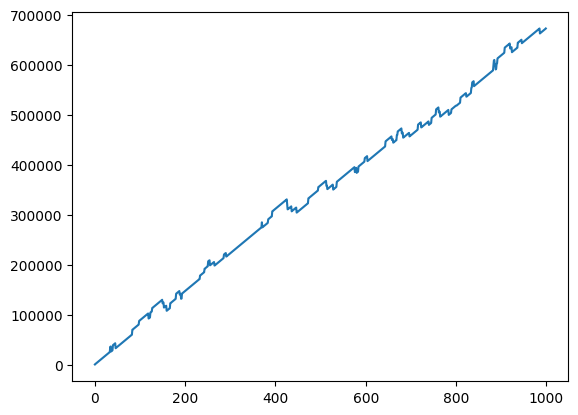

In [66]:
history = test_agents(RaisedPlayer, RuleBasedAgent, num_games=1_000)
history = np.array(history) * 1000 / 20 # convert to mbb
cumulative_sum = np.cumsum(history)
plt.plot(cumulative_sum)

673.0


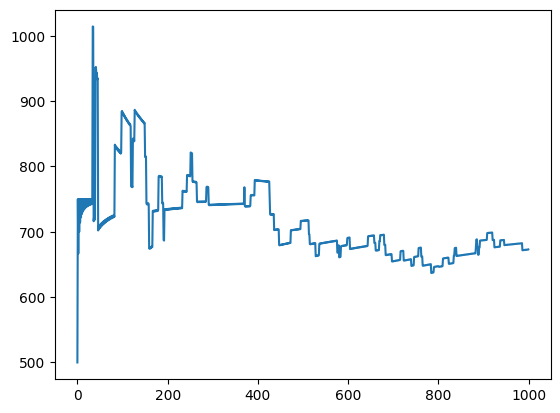

In [67]:
avg_change_over_time = cumulative_sum / np.arange(1, len(cumulative_sum) + 1)
print(avg_change_over_time[-1])
plt.plot(avg_change_over_time)